In [2]:
import json
from pathlib import Path
from rdkit import Chem
from tqdm import tqdm
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
import matplotlib.pyplot as plt
from src.ergochemics.draw import draw_molecule, draw_reaction
from IPython.display import SVG
from ast import literal_eval
from collections import Counter
import torch

In [ ]:
uniprot = "P0A2W6"
dir1 = "/home/stef/quest_data/hiec/data/time_split/esm2"
dir2 = "/home/stef/quest_data/hiec/data/time_split/esm2_repeat"
vec1 = torch.load(f"{dir1}/{uniprot}.pt")['representations'][33]
vec2 = torch.load(f"{dir2}/{uniprot}.pt")['representations'][33]

In [11]:
(vec1 == vec2).all()

tensor(True)

In [30]:
for file in Path(dir2).iterdir():
    uniprot = file.stem
    vec1 = torch.load(f"{dir1}/{uniprot}.pt")['representations'][33]
    vec2 = torch.load(f"{dir2}/{uniprot}.pt")['representations'][33]
    if not torch.isclose(vec1, vec2).all():
        print(uniprot, (vec1 - vec2).abs().max())

Q8IV63 tensor(7.1526e-06)
P0A281 tensor(4.4107e-06)
B5X4Y9 tensor(5.2452e-06)
Q5XIL6 tensor(5.0068e-06)
T2HG31 tensor(4.7684e-06)
O24769 tensor(5.2452e-06)
A0A223GB52 tensor(6.1989e-06)
P0DXH6 tensor(5.0068e-06)
Q2YDN8 tensor(6.1989e-06)
Q4V9J0 tensor(7.3910e-06)
Q5R5E9 tensor(7.6294e-06)
Q7SZS2 tensor(4.4703e-06)
Q60866 tensor(4.7684e-06)
F4IY03 tensor(8.3447e-06)


In [19]:
torch.isclose(vec1, vec2).sum() / vec1.numel()

tensor(0.9190)

In [21]:
(vec1 - vec2).abs().max()

tensor(4.4107e-06)

In [19]:
def rc_to_nest(rc: str) -> tuple[tuple[tuple[int]]]:
    '''
    Convert string representation of reaction center to nested tuple representation.
    '''
    return tuple(
        tuple(
            tuple(
                int(aidx) for aidx in mol.split(",") if aidx != ""
            )
            for mol in side.split(";")
        )
        for side in rc.split(">>")
    )

In [20]:
def quick_roc(fp: str):
    df = pd.read_parquet(fp)
    score = roc_auc_score(df['y'], df['logits'])
    return score

In [21]:
# Trained on rc split data (missing 20% of rcs therefore...) which has arc negs. Test neg samples are ARC
run_ids = {
    "rc_agg": "7446e660756f4cf486a9b17372880abf",
    "cgr": "a20a704601954d8983435696493f7638",
    "bom": "8f3e92d3688c4eaaa754c03f821a5f50",
    "mfp": "312b2ccd7ab8476eaf2f02559b472f37"

}
fps = {
    k: f"/home/stef/quest_data/hiec/results/predictions/{run_id}/time_split_alternate_reaction_center_target_output.parquet"
    for k, run_id in run_ids.items()

}
for k, fp in fps.items():
    score = quick_roc(fp)
    print(f"{k}: {score}")

rc_agg: 0.7874361793960847
cgr: 0.7748261878115119
bom: 0.9174610352710504
mfp: 0.8231988979694529


In [22]:
# ***
# Trained on random rxn split data - better stratified- which has arc negs. Test neg samples are ARC
run_ids = {
    "rc_agg": "7f9e852795664f9d877f9c0b05ee4177",
    "rc_cxn": "575b67f3c7ac4d3b896a5a6e2ecf9350",
    "cgr": "e8554547daa542a091131c518dcf002a",
    "bom": "e35758e78f444ffcb352891483f11dcd",
    "mfp": "ac4018e22f994c26921bc3a3a0797d58"

}
fps = {
    k: f"/home/stef/quest_data/hiec/results/predictions/{run_id}/time_split_alternate_reaction_center_target_output.parquet"
    for k, run_id in run_ids.items()

}
for k, fp in fps.items():
    score = quick_roc(fp)
    print(f"{k}: {score}")

rc_agg: 0.7973699892421343
rc_cxn: 0.8159367964551097
cgr: 0.8706885847333741
bom: 0.8437277685236998
mfp: 0.8424805013685914


In [23]:
# ***
# Trained on rcmcs split, which is better stratified, and has random negs. Test neg samples are random
run_ids = {
    "rc_agg": "8a155bc5673b4c6aa8667dd55755fe0b",
    "rc_cxn": "5ca6ba7b8aec4b81a366e9138b9c09b0",
    "cgr": "2a7b803f790143f0b14a1955117cb393",
    "bom": "ff90895a6070499b8fdcdc0982526885",
    "mfp": "fb3c7a9061a744fba7dabf9d50092414"

}
fps = {
    k: f"/home/stef/quest_data/hiec/results/predictions/{run_id}/time_split_random_target_output.parquet"
    for k, run_id in run_ids.items()

}
for k, fp in fps.items():
    score = quick_roc(fp)
    print(f"{k}: {score}")

rc_agg: 0.7698837232199117
rc_cxn: 0.8777265805503046
cgr: 0.8072079788909893
bom: 0.8790687027410208
mfp: 0.8555173217286285


In [24]:
# Trained on rcmcs split, which is better stratified, and has random negs. Test neg samples are ARC
run_ids = {
    "rc_agg": "8a155bc5673b4c6aa8667dd55755fe0b",
    "cgr": "2a7b803f790143f0b14a1955117cb393",
    "bom": "ff90895a6070499b8fdcdc0982526885",
    "mfp": "fb3c7a9061a744fba7dabf9d50092414"

}
fps = {
    k: f"/home/stef/quest_data/hiec/results/predictions/{run_id}/time_split_alternate_reaction_center_target_output.parquet"
    for k, run_id in run_ids.items()

}
for k, fp in fps.items():
    score = quick_roc(fp)
    print(f"{k}: {score}")

rc_agg: 0.5570188566297516
cgr: 0.4409893928746491
bom: 0.4696709795730689
mfp: 0.6693223791800598


In [25]:
# Trained on random rxn split data - better stratified- which has arc negs. Test neg samples are random
run_ids = {
    "rc_agg": "7f9e852795664f9d877f9c0b05ee4177",
    "cgr": "e8554547daa542a091131c518dcf002a",
    "bom": "e35758e78f444ffcb352891483f11dcd",
    "mfp": "ac4018e22f994c26921bc3a3a0797d58"

}
fps = {
    k: f"/home/stef/quest_data/hiec/results/predictions/{run_id}/time_split_random_target_output.parquet"
    for k, run_id in run_ids.items()

}
for k, fp in fps.items():
    score = quick_roc(fp)
    print(f"{k}: {score}")

rc_agg: 0.4683911271266541
cgr: 0.4621150362318841
bom: 0.5756791837324092
mfp: 0.5389776635685781


In [26]:
fp = "/home/stef/quest_data/hiec/results/predictions/7446e660756f4cf486a9b17372880abf/time_split_random_target_output.parquet"
score = quick_roc(fp)
print(f"rc_agg random: {score}")

rc_agg random: 0.47093868147448015


In [27]:

fp = "/home/stef/quest_data/hiec/results/predictions/8a155bc5673b4c6aa8667dd55755fe0b/time_split_random_target_output.parquet"
score = quick_roc(fp)
print(f"rc_agg random: {score}")

rc_agg random: 0.7698837232199117


In [28]:
new_rxns = pd.read_csv("/home/stef/quest_data/hiec/data/time_split/250915_sprhea_time_split_raw.tsv", sep="\t")
new_rxns.head()

,id,sequence,existence,reviewed,ec,organism,name,subunit,rxn_id,reverse,db_ids,rhea_idx,smarts,am_smarts,rule,template_aidxs,rule_id,rev_rxn_id,rev_rule_id
0,Q9VXN0,MSCAKPHILIIEPFYGGSHKQLIGALIEGLNHGDSEIFSLPAKKWH...,Evidence at transcript level,reviewed,2.4.1.110,Drosophila melanogaster (Fruit fly),tRNA-queuosine alpha-mannosyltransferase (EC 2...,False,c19cf7ba78299fcf7054ef7cf86e7ce4d52a44d7,*OC1C(COP(*)(=O)O)OC(n2cc(CNC3C=CC(OC4OC(CO)C(...,RHEA:12886,690,Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C...,[NH2:71][c:69]1[n:67][c:65]2[c:68]([n:66][cH:6...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],"21,20;21>>21,22;19",517,0742ced3ba6b05ecd49fac26a95afcb5ac35f850,517
1,P26403,MKITLIIPTYNAGSLWPNVLDAIKQQTIYPDKLIVIDSGSKDETVP...,Evidence at protein level,reviewed,2.4.1.377,Salmonella typhimurium (strain LT2 / SGSC1412 ...,O-antigen chain rhamnosyltransferase RfbN (EC ...,False,3bf629a530f9a2f3a568796888146af735cd814d,CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=...,RHEA:66953,13619,Cc1cn(C2CC(O)C(COP(=O)(O)OP(=O)(O)OC3OC(C)C(O)...,[CH3:108][c:105]1[cH:103][n:102]([CH:101]2[CH2...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],"19,18;72>>72,73;17",517,670bb65c1cf604c9bc1676fa7ca0c93585d2c5e2,517
2,G3UYQ4,MASEEKTEELHPFTDIFNEDETDRNCLLSKPTCFIIFGKPGAGKTT...,Evidence at transcript level,reviewed,2.7.4.4; 2.7.4.6,Mus musculus (Mouse),Adenylate kinase 9 (EC 2.7.4.4) (EC 2.7.4.6),False,e94fa89a1f352a07afd07e79cb4fefe563629328,Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)...,RHEA:79864,16809,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,[O:54]=[c:53]1[cH:50][cH:48][n:46]([CH:43]2[O:...,[#8:1].[#8:2]-[#15:3]>>[#8:2].[#8:1]-[#15:3],"16;20,21>>19;17,18",637,c71a7c603f5c77b97f9ed153872bce346110c573,637
3,Q5FVH2,MKPKLMYQELKVPVEEPAGELPMNEIEAWKAAEKKARWVLLVLILA...,Evidence at protein level,reviewed,3.1.16.1; 3.1.4.-,Rattus norvegicus (Rat),"5'-3' exonuclease PLD3 (EC 3.1.16.1) ((S,S)-bi...",False,9c806f5e2fd3b2bd22f529ff066393dcdb09c79f,CCCCCCCCC=CCCCCCCCC(=O)OCC(O)CO.CCCCCCCCC=CCCC...,RHEA:82569,17412,CCCCCCCCC=CCCCCCCCC(=O)OCC(O)COP(=O)(O)OCC(O)C...,[CH3:20][CH2:19][CH2:18][CH2:17][CH2:16][CH2:1...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],"17,19;0>>17,19;33",517,a7a00609de5efcc60e30fb77f10922af59fbdbaf,517
4,J9VPA2,MAFAGVGQGLGTYDRTEQTSGASLGRVASRAHFTDTHPSDDLPAQT...,Evidence at protein level,reviewed,NaN,Cryptococcus neoformans var. grubii serotype A...,ABC multidrug transporter AFR2,False,23281d7a637c745f1978c29d20b03cdf6bd5931b,CC(c1ncncc1F)C(O)(Cn1cncn1)c1ccc(F)cc1F.Nc1ncn...,RHEA:61914,12377,CC(c1ncncc1F)C(O)(Cn1cncn1)c1ccc(F)cc1F.Nc1ncn...,[CH3:6][CH:3]([c:7]1[n:11][cH:18][n:24][cH:19]...,[#6:1]-[#8:2].[#8:3].[#8:4]-[#15:5]>>[#6:1]-[#...,"9,10;21;2,1>>9,10;0;22,23",607,77a9b2f20f10b17985b01d0edcdfbfc631542523,228


In [29]:
i = 6

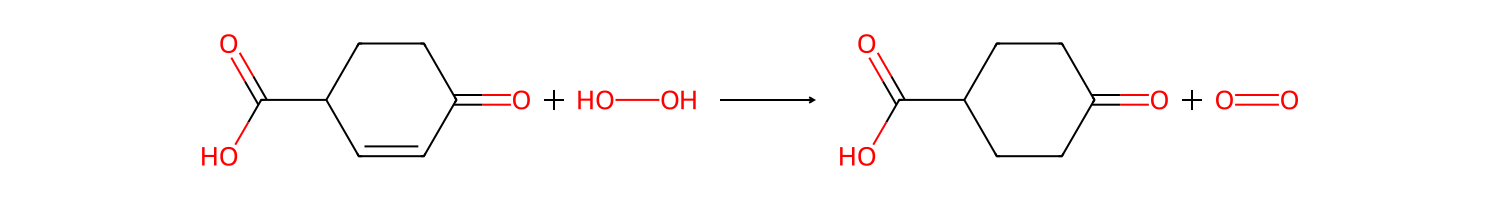

Reactants:


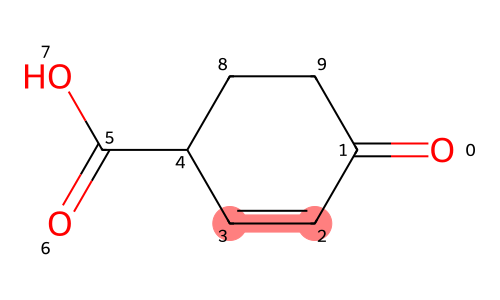

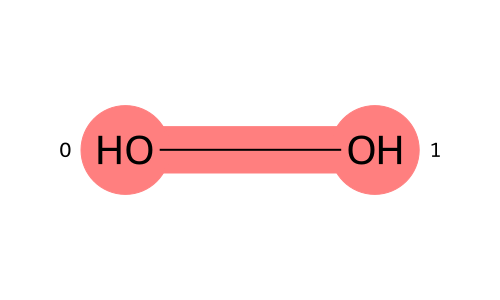

Products:


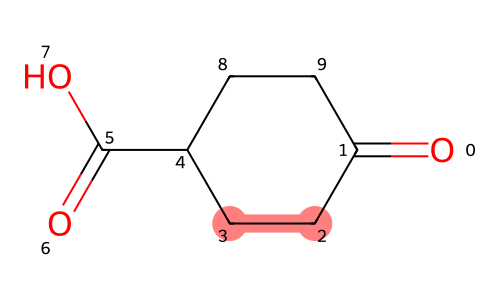

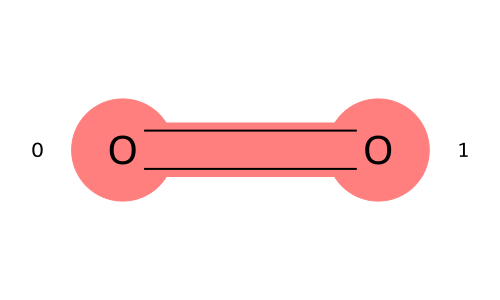

In [30]:
i += 1
smarts = new_rxns.loc[i, 'smarts']
rcs = rc_to_nest(new_rxns.loc[i, 'template_aidxs'])
display(SVG(draw_reaction(smarts)))
rcts, pdts = [side.split(".") for side in smarts.split(">>")]

print("Reactants:")
for rct, rc in zip(rcts, rcs[0]):
    display(SVG(draw_molecule(rct, highlight_atoms=[aidx for aidx in rc], draw_options={'addAtomIndices': True}, size=(500, 300))))

print("Products:")
for pdt, rc in zip(pdts, rcs[1]):
    display(SVG(draw_molecule(pdt, highlight_atoms=[aidx for aidx in rc], draw_options={'addAtomIndices': True}, size=(500, 300))))

In [68]:
with open(Path("/home/stef/quest_data/hiec/data") / "sprhea" / "v3_folded_pt_ns.json", 'r') as f:
    rxns_24 = json.load(f)

In [69]:
rules = pd.read_csv("/home/stef/hiec/artifacts/rc_plus_0_rules.csv", sep=",")
rules['ni_ids'] = rules['ni_ids'].apply(literal_eval)
new_to_old = {}
for _, row in rules.iterrows():
    for elt in row['ni_ids']:
        new_to_old[row['id']] = elt

In [70]:
old_rules = []
for elt in rxns_24.values():
    old_rules.extend(elt['min_rules'])

old_rule_cts = Counter(old_rules)
old_rules = set(old_rules)

In [72]:
new_rules = list()
for _, row in new_rxns.iterrows():
    new_rules.append(new_to_old.get(row['rule_id'], None))
    new_rules.append(new_to_old.get(row['rev_rule_id']))

new_rule_cts = Counter(new_rules)
new_rules = set(new_rules)
new_rules.discard(None)

In [73]:
print(f"Number of new rules: {len(new_rules)}")
print(f"Number of old rules: {len(old_rules)}")
print(f"Number of overlapping rules: {len(new_rules.intersection(old_rules))}")

Number of new rules: 113
Number of old rules: 748
Number of overlapping rules: 100


In [75]:
srt_new_rules = sorted(new_rule_cts.items(), key=lambda x: x[1], reverse=True)
srt_old_rules = sorted(old_rule_cts.items(), key=lambda x: x[1], reverse=True)
k = 10
for new, old in zip(srt_new_rules[:k], srt_old_rules[:k]):
    print(f"New rule: {new}, Old rule: {old}")

New rule: ('rule0105', 214), Old rule: ('rule0001', 824)
New rule: ('rule0517', 182), Old rule: ('rule0007', 463)
New rule: ('rule0846', 54), Old rule: ('rule0006', 463)
New rule: ('rule0847', 54), Old rule: ('rule0002', 443)
New rule: ('rule0429', 39), Old rule: ('rule0003', 442)
New rule: ('rule0430', 39), Old rule: ('rule0021', 384)
New rule: ('rule1222', 28), Old rule: ('rule0022', 384)
New rule: ('rule0394', 26), Old rule: ('rule0014', 231)
New rule: ('rule0393', 26), Old rule: ('rule0015', 231)
New rule: ('rule0283', 24), Old rule: ('rule0012', 220)


In [79]:
for new in srt_new_rules[:k]:
    print(f"Rule: {new} occurs {new_rule_cts[new[0]]} times vs old rule occurs {old_rule_cts[new[0]]} times")

Rule: ('rule0105', 214) occurs 214 times vs old rule occurs 7 times
Rule: ('rule0517', 182) occurs 182 times vs old rule occurs 2 times
Rule: ('rule0846', 54) occurs 54 times vs old rule occurs 24 times
Rule: ('rule0847', 54) occurs 54 times vs old rule occurs 24 times
Rule: ('rule0429', 39) occurs 39 times vs old rule occurs 5 times
Rule: ('rule0430', 39) occurs 39 times vs old rule occurs 5 times
Rule: ('rule1222', 28) occurs 28 times vs old rule occurs 1 times
Rule: ('rule0394', 26) occurs 26 times vs old rule occurs 34 times
Rule: ('rule0393', 26) occurs 26 times vs old rule occurs 34 times
Rule: ('rule0283', 24) occurs 24 times vs old rule occurs 16 times


In [80]:
for old in srt_old_rules[:k]:
    print(f"Rule: {old} occurs {old_rule_cts[old[0]]} times vs new rule occurs {new_rule_cts[old[0]]} times")

Rule: ('rule0001', 824) occurs 824 times vs new rule occurs 0 times
Rule: ('rule0007', 463) occurs 463 times vs new rule occurs 0 times
Rule: ('rule0006', 463) occurs 463 times vs new rule occurs 0 times
Rule: ('rule0002', 443) occurs 443 times vs new rule occurs 9 times
Rule: ('rule0003', 442) occurs 442 times vs new rule occurs 9 times
Rule: ('rule0021', 384) occurs 384 times vs new rule occurs 0 times
Rule: ('rule0022', 384) occurs 384 times vs new rule occurs 0 times
Rule: ('rule0014', 231) occurs 231 times vs new rule occurs 0 times
Rule: ('rule0015', 231) occurs 231 times vs new rule occurs 0 times
Rule: ('rule0012', 220) occurs 220 times vs new rule occurs 0 times


In [85]:
(np.cumsum([np.array([x[1] for x in srt_new_rules])]) / sum([x[1] for x in srt_new_rules]))[20]

np.float64(0.7563405797101449)

In [17]:
file_paths = [f"gs://public-datasets-deepmind-alphafold-v4/AF-{u}-F1-model_v4.cif" for u in new_rxns['id'].unique()]
output_file = '/home/stef/quest_data/hiec/data/time_split/uniprot_cif_paths.txt' 
with open(output_file, 'w') as file:
    file.write('\n'.join(file_paths))